In [2]:
# Read data from the cleaned csv file
import pandas as pd

df = pd.read_csv('cleaned_data.csv')
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Hour
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,8
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,8
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8


In [3]:
# Data Preprocessing to Forecast
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
# Aggregate sales by daily total price
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
daily_sales.rename(columns={'InvoiceDate': 'Date'}, inplace=True)

In [7]:
# Sort by date
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales = daily_sales.sort_values(by='Date').reset_index(drop=True)
print(daily_sales)

          Date  TotalPrice
0   2010-12-01    46376.49
1   2010-12-02    47316.53
2   2010-12-03    23921.71
3   2010-12-05    31771.60
4   2010-12-06    31215.64
..         ...         ...
300 2011-12-05    58202.21
301 2011-12-06    46144.04
302 2011-12-07    69354.21
303 2011-12-08    50519.41
304 2011-12-09   184349.28

[305 rows x 2 columns]


In [19]:
#Feature Engineering - Create total price lagged features for time series forecasting with XGBregressor

In [8]:
# Create lag features (previous sales as input variables)
def create_lag_features(data, lag_days):
    for lag in range(1, lag_days + 1):
        data[f'Lag_{lag}'] = data['TotalPrice'].shift(lag)
    return data

In [10]:
# Define the number of lag days
lag_days = 7 

In [11]:
# Create lag features
daily_sales = create_lag_features(daily_sales, lag_days)
daily_sales.head()

,Date,TotalPrice,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2010-12-01,46376.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-12-02,47316.53,46376.49,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-12-03,23921.71,47316.53,46376.49,NaN,NaN,NaN,NaN,NaN
3,2010-12-05,31771.60,23921.71,47316.53,46376.49,NaN,NaN,NaN,NaN
4,2010-12-06,31215.64,31771.60,23921.71,47316.53,46376.49,NaN,NaN,NaN


In [73]:
#Drop Missing Values from Lag fetaures

In [75]:
# Drop NaN values resulting from lag feature creation
daily_sales = daily_sales.dropna().reset_index(drop=True)
daily_sales

,Date,TotalPrice,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2010-12-09,38231.90,39248.82,53795.31,31215.64,31771.60,23921.71,47316.53,46376.49
1,2010-12-10,33650.28,38231.90,39248.82,53795.31,31215.64,31771.60,23921.71,47316.53
2,2010-12-12,17305.77,33650.28,38231.90,39248.82,53795.31,31215.64,31771.60,23921.71
3,2010-12-13,27642.68,17305.77,33650.28,38231.90,39248.82,53795.31,31215.64,31771.60
4,2010-12-14,29322.30,27642.68,17305.77,33650.28,38231.90,39248.82,53795.31,31215.64
...,...,...,...,...,...,...,...,...,...
293,2011-12-05,58202.21,20375.96,44713.69,44533.99,41481.23,48851.68,51831.67,17300.96
294,2011-12-06,46144.04,58202.21,20375.96,44713.69,44533.99,41481.23,48851.68,51831.67
295,2011-12-07,69354.21,46144.04,58202.21,20375.96,44713.69,44533.99,41481.23,48851.68
296,2011-12-08,50519.41,69354.21,46144.04,58202.21,20375.96,44713.69,44533.99,41481.23


In [77]:
#Create the train , test split

In [12]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

In [13]:
train.head() #just to see the how train test looks like

,Date,TotalPrice,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2010-12-01,46376.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-12-02,47316.53,46376.49,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-12-03,23921.71,47316.53,46376.49,NaN,NaN,NaN,NaN,NaN
3,2010-12-05,31771.60,23921.71,47316.53,46376.49,NaN,NaN,NaN,NaN
4,2010-12-06,31215.64,31771.60,23921.71,47316.53,46376.49,NaN,NaN,NaN


In [87]:
#Model Training

In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define features and target
X_train = train.drop(columns=['Date', 'TotalPrice'])
y_train = train['TotalPrice']
X_test = test.drop(columns=['Date', 'TotalPrice'])
y_test = test['TotalPrice']

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

In [15]:
# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')

In [16]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_absolute_error', verbose=1)

In [17]:
# Get best parameters
best_params = grid_search.best_params_

In [18]:
# Train final model with best parameters
best_xgb_model = XGBRegressor(objective='reg:squarederror', **best_params)
best_xgb_model.fit(X_train, y_train)

# Print model summary
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [117]:
#save the pickeled model
import pickle
pickle.dump(best_xgb_model, open('best_xgb_model.pkl', 'wb'))

In [19]:
# Predict on test set
y_pred = best_xgb_model.predict(X_test)
y_pred

array([27716.082, 27389.447, 25964.736, 28233.646, 29648.781, 31661.87 ,
       29574.996, 27472.998, 44179.31 , 38828.297, 37421.016, 33371.84 ,
       28255.797, 27964.436, 28645.557, 30013.404, 27985.494, 27995.041,
       27976.236, 27666.166, 27876.398, 33330.984, 32382.13 , 35260.945,
       32666.188, 27519.645, 30441.941, 29453.375, 29679.78 , 36521.59 ,
       28901.744, 25950.443, 29420.969, 29820.906, 31553.475, 37572.03 ,
       35431.965, 29926.887, 30475.758, 34781.68 , 37347.39 , 35262.836,
       31919.967, 30089.668, 37672.08 , 34954.9  , 34009.934, 35713.293,
       27327.744, 29530.355, 28471.846, 34592.152, 35820.477, 30695.656,
       25824.99 , 27784.139, 36310.805, 32857.86 , 30620.316, 30492.33 ,
       28585.18 ], dtype=float32)

## Model Evaluation

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print("MAPE : ", mape )

### Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ", mae )

### Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE : ", rmse )

### Output best parameters and model performance
print("Best Prameters for the model : ", best_params )

MAPE :  0.3449454206841588
MAE :  16690.45152279713
RMSE :  26954.334870108356
Best Prameters for the model :  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


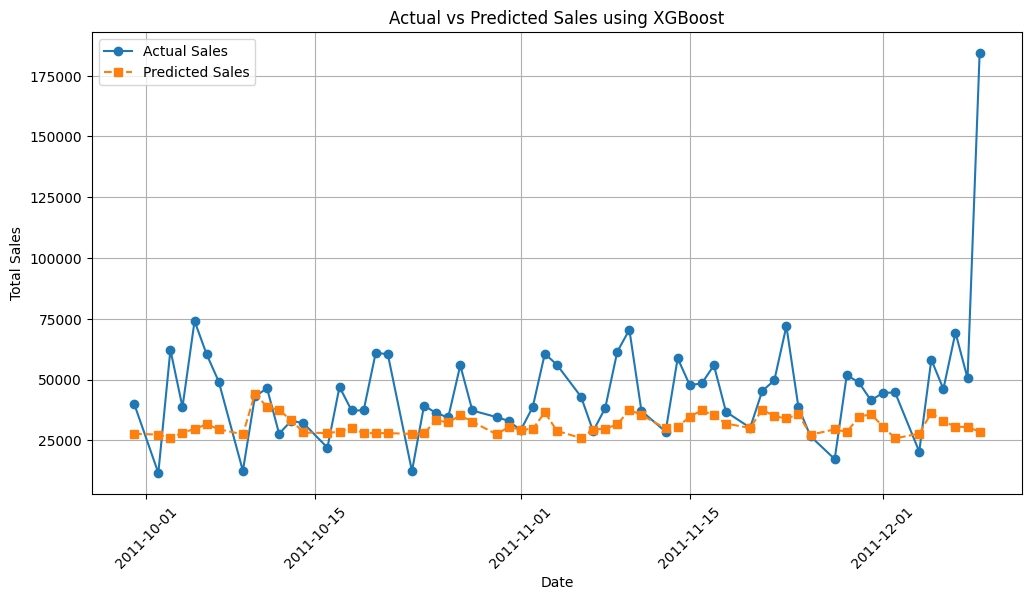

In [22]:
import matplotlib.pyplot as plt

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label="Actual Sales", marker='o', linestyle='-')
plt.plot(test['Date'], y_pred, label="Predicted Sales", marker='s', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Actual vs Predicted Sales using XGBoost")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Evaluation Insights on the XGBoost Model

Model's evaluation metrics are as follows:

### Mean Absolute Error (MAE): **16,690.45**
- This means that, on average, the model's predictions are off by **16,690.45 units** in terms of sales.
- If the sales are in dollars, this suggests a relatively **high deviation**.

### Root Mean Squared Error (RMSE): **26,954.33**
- RMSE penalizes larger errors more than MAE, and a high RMSE indicates that the model struggles with **some large deviations**.
- The large gap between **MAE and RMSE** suggests the presence of **extreme errors (outliers)** in the predictions.

### Mean Absolute Percentage Error (MAPE): **33.02%**
- This means that, on average, the model's predictions are off by **34%** of the actual sales value.
- For time series forecasting:
  - A **MAPE below 10%** is generally considered **excellent**.
  - A **MAPE below 20%** is considered **good**.
- **33% suggests the model is not very accurate** and may need **improvements**.
